torch.Size([4, 3, 32, 32]) torch.Size([4])


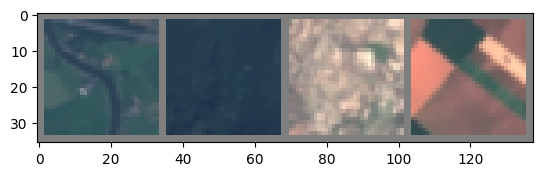

River Forest PermanentCrop AnnualCrop


In [23]:
# Necessary Imports
import torch
import torchvision
import seaborn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set the directory where your data is stored
data_dir = 'EuroSAT_RGB'

# Set the batch size for training and testing
batch_size = 4

# Define a transformation to apply to the images
transform = transforms.Compose(
    [transforms.Resize((32, 32)),  # Resize images to 32x32
     transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize the images

# Load the training data
dataset = ImageFolder(root=data_dir, transform=transform)

# Create data loaders for training and testing datasets
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print some samples to verify the data loading
data_iter = iter(data_loader)
images, labels = next(data_iter)  # Use next() instead of data_iter.next()
print(images.shape, labels.shape)

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

 # Get some random training images
dataiter = iter(data_loader)
images, labels = next(dataiter)  # Use next() here as well

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % dataset.classes[labels[j]] for j in range(batch_size)))

In [24]:
from torch.utils.data import random_split

# Total number of images
total_images = len(dataset)

# Splitting the dataset
train_size = int(total_images * 0.8)
test_size = total_images - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Setting up DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
class SatelliteNet(nn.Module):
    def __init__(self):
        super(SatelliteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)  # Input channels = 3 for RGB images
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(dataset.classes))  # Output size = Number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = SatelliteNet()
print(model)

SatelliteNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 1.2811198836427045
Epoch 2, Loss: 0.9210050483367026
Epoch 3, Loss: 0.8127668705654624
Epoch 4, Loss: 0.7332519596057978
Epoch 5, Loss: 0.6718016320998194
Epoch 6, Loss: 0.6176651422231548
Epoch 7, Loss: 0.5799342335957098
Epoch 8, Loss: 0.5500946855521976
Epoch 9, Loss: 0.5310325839008201
Epoch 10, Loss: 0.507780645660004


Accuracy of the network on test images: 79 %


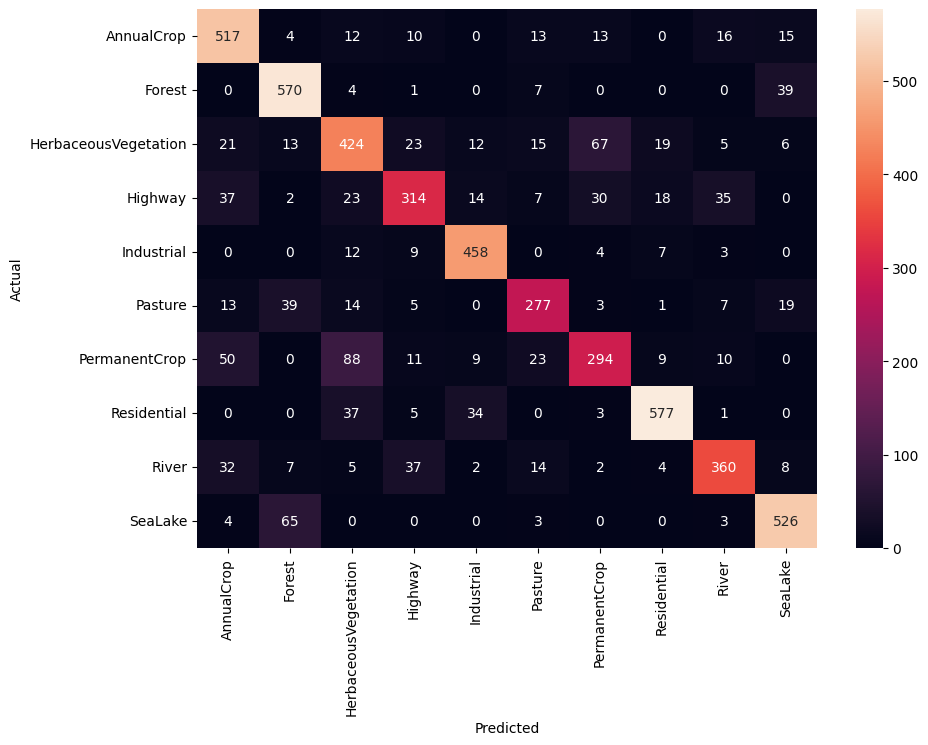

In [27]:
# Evaluate on test set
model.eval()
total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy of the network on the test images: 79.94 %


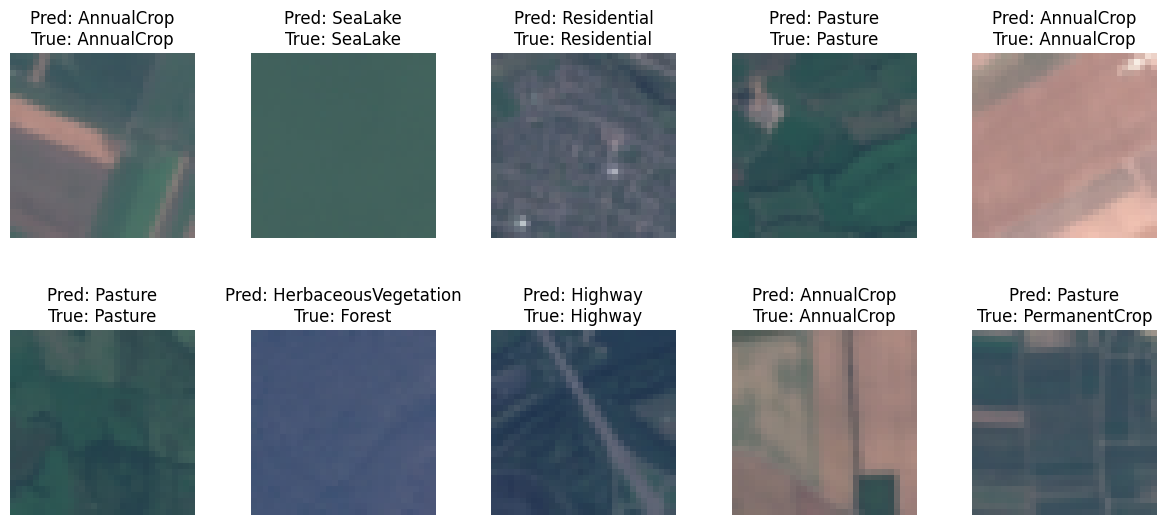

C:\Users\Evan\AppData\Local\Temp\ipykernel_17624\2049228979.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + class_names, rotation=90)
C:\Users\Evan\AppData\Local\Temp\ipykernel_17624\2049228979.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + class_names)


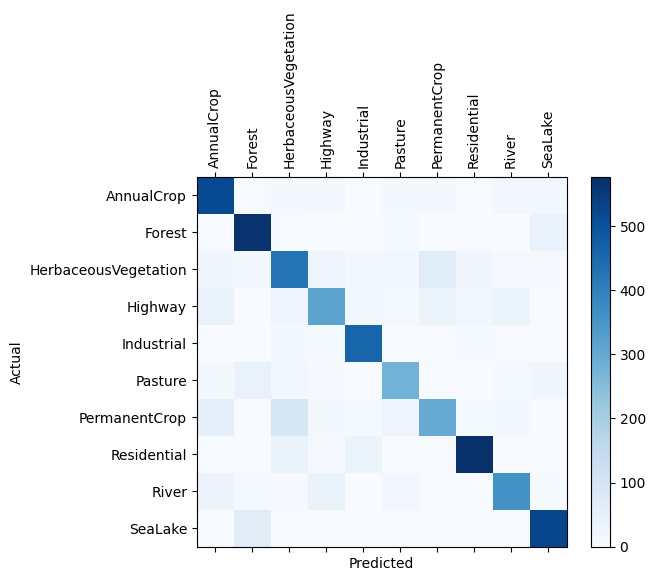

In [28]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
class_names = dataset.classes
num_classes = len(class_names)
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

# Containers for display purposes
images_to_show = []
pred_classes = []
true_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

        # Collect some images to display
        if len(images_to_show) < 10:  # Limit the number of images to display
            images_to_show.extend(images)
            pred_classes.extend(predicted)
            true_classes.extend(labels)

# Calculate and print the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')

# Show example images with predicted and true labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace = 0.5)
axs = axs.ravel()

for i in range(10):
    img = images_to_show[i] / 2 + 0.5     # unnormalize
    img = np.transpose(img.numpy(), (1, 2, 0))  # Rearrange dimensions to display

    axs[i].imshow(img)
    axs[i].set_title(f'Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[true_classes[i]]}')
    axs[i].axis('off')

plt.show()

# Display the confusion matrix using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix.numpy(), cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xticklabels([''] + class_names, rotation=90)
ax.set_yticklabels([''] + class_names)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()